In [1]:
%env TT_METAL_HOME=/home/ubuntu/tt-metal
%env TT_METAL_RUNTIME_ROOT=/home/ubuntu/tt-metal

env: TT_METAL_HOME=/home/ubuntu/tt-metal
env: TT_METAL_RUNTIME_ROOT=/home/ubuntu/tt-metal


In [2]:
model_id = "meta-llama/Llama-3.2-1B-Instruct" 
CONFIG = "training_shakespeare_llama3_2_1B_fixed.yaml"

In [3]:
model_id = "Qwen/Qwen3-0.6B" 
CONFIG = "training_shakespeare_qwen3_0_6B.yaml"

model_id = "Qwen/Qwen3-1.7B" 
CONFIG = "training_shakespeare_qwen3_1_7B.yaml"

model_id =  "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
CONFIG = "training_shakespeare_tinyllama.yaml"

model_id = "Qwen/Qwen3-4B"
CONFIG = "training_shakespeare_qwen3_4B.yaml"

In [4]:
import ttml

2026-01-14 05:29:33.168 | DEBUG    | ttnn:<module>:77 - Initial ttnn.CONFIG:
Config{cache_path=/home/ubuntu/.cache/ttnn,model_cache_path=/home/ubuntu/.cache/ttnn/models,tmp_dir=/tmp/ttnn,enable_model_cache=false,enable_fast_runtime_mode=true,throw_exception_on_fallback=false,enable_logging=false,enable_graph_report=false,enable_detailed_buffer_report=false,enable_detailed_tensor_report=false,enable_comparison_mode=false,comparison_mode_should_raise_exception=false,comparison_mode_pcc=0.9999,root_report_path=generated/ttnn/reports,report_name=std::nullopt,std::nullopt}


In [5]:
import os
import sys
import datasets
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import Optional

import ttml
from ttml.common.config import DeviceConfig, get_training_config, load_config
from ttml.common.model_factory import TransformerModelFactory
from ttml.common.utils import round_up_to_tile, create_optimizer, initialize_device
#from ttml import build_causal_mask

#import tt_serialization

In [6]:
TILE_SIZE = 32

def round_up(value: int) -> int:
    return ((value + TILE_SIZE - 1) // TILE_SIZE) * TILE_SIZE

def build_causal_mask(T: int):
    m = np.tril(np.ones((T, T), dtype=np.float32))
    return m.reshape(1, 1, T, T)

def create_causal_mask_kv(query_len: int, prompt_len: int = 0) -> ttml.autograd.Tensor:
    whole_len = prompt_len + query_len
    padded_q = round_up(query_len)
    padded_w = round_up(whole_len)
    mask = np.zeros((padded_q, padded_w), dtype=np.float32)
    for i in range(query_len):
        for j in range(prompt_len + i + 1):
            mask[i, j] = 1.0
    return ttml.autograd.Tensor.from_numpy(mask.reshape(1, 1, padded_q, padded_w), ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16)

def tokens_to_tensor_kv(tokens: list) -> ttml.autograd.Tensor:
    padded_len = round_up(len(tokens))
    padded = np.zeros(padded_len, dtype=np.uint32)
    padded[:len(tokens)] = tokens
    return ttml.autograd.Tensor.from_numpy(padded.reshape(1, 1, 1, padded_len), ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.UINT32)

In [7]:
class OptimParamSetter:
    def __init__(self, optim):
        self.optim = optim
        self._warned_lr = False
        self._warned_beta1 = False

    def set_lr(self, lr: float):
        self.optim.set_lr(float(lr))

    def set_beta1(self, beta1: float):
        raise NotImplementedError(
            "set_beta1 is not implemented in TTML AdamW optimizer."
        )


def build_logits_mask(vocab_size: int, padded_vocab_size: int) -> ttml.autograd.Tensor:
    logits_mask = np.zeros((1, 1, 1, padded_vocab_size), dtype=np.float32)
    logits_mask[:, :, :, vocab_size:] = 1e4
    return ttml.autograd.Tensor.from_numpy(
        logits_mask, ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16
    )  # [1,1,1,T], bfloat16"


class CollateFn:
    def __init__(self, eos_token_id, max_sequence_length, padded_vocab_size):
        self.eos_token_id = eos_token_id
        self.max_sequence_length = max_sequence_length
        self.padded_vocab_size = padded_vocab_size

    def collate_fn(self, batch):
        X = [sample[0] for sample in batch]
        Y = [sample[1] for sample in batch]

        batch_size = len(X)

        data_np = np.full(
            (batch_size, self.max_sequence_length), self.eos_token_id, dtype=np.uint32
        )
        mask_lens = []

        for i in range(batch_size):
            x_tokens = X[i]
            y_tokens = Y[i]

            # Concatenate question + answer
            combined_length = len(x_tokens) + len(y_tokens)
            if combined_length > self.max_sequence_length:
                # Truncate if too long, prioritizing keeping the answer
                available_space = self.max_sequence_length - len(y_tokens)
                if available_space > 0:
                    x_tokens = x_tokens[:available_space]
                    data_np[i, : len(x_tokens)] = x_tokens
                    data_np[i, len(x_tokens) : len(x_tokens) + len(y_tokens)] = y_tokens

                else:
                    # If answer is too long, just use the answer
                    data_np[i, : self.max_sequence_length] = y_tokens[
                        : self.max_sequence_length
                    ]
                    x_tokens = []

            else:
                # Normal case: concatenate question + answer

                data_np[i, : len(x_tokens)] = x_tokens
                data_np[i, len(x_tokens) : len(x_tokens) + len(y_tokens)] = y_tokens

            mask_lens.append(len(x_tokens))

        # Shape: [batch_size, 1, 1, max_sequence_length]
        X_np = np.expand_dims(data_np, axis=(1, 2))

        y_np = np.full(
            (batch_size, self.max_sequence_length), self.eos_token_id, dtype=np.uint32
        )  # Shape: [batch, seq_len]
        y_np[:, 0:-1] = X_np[:, 0, 0, 1:]  # Shift left by 1

        loss_scaler_np = np.full(
            (batch_size, 1, self.max_sequence_length, 1), 1.0, dtype=np.float32
        )
        for i, mask_len in enumerate(mask_lens):
            loss_scaler_np[i, :, :mask_len, :] = 0.0
            pad_positions = X_np[i, 0, 0, :] == self.eos_token_id
            loss_scaler_np[i, :, pad_positions, :] = 0.0
        loss_scaler_ratio = (
            self.max_sequence_length * batch_size / np.sum(loss_scaler_np)
        )
        loss_scaler_np = loss_scaler_np * loss_scaler_ratio

        return X_np, y_np, loss_scaler_np

    def __call__(self, batch):
        return self.collate_fn(batch)



In [8]:
def get_batch_generator(
    dataloader,
    batch_size,
    max_sequence_length,
    padded_vocab_size,
    tokenizer,
    device_config=None,
):
    """Custom data generator for GSM8K dataset."""
    mapper = None
    if device_config is not None:
        device = ttml.autograd.AutoContext.get_instance().get_device()
        mapper = ttml.core.distributed.shard_tensor_to_mesh_mapper(device, 0)

    while True:
        for batch in dataloader:
            X_np, y_np, loss_scaler_np = batch

            X = ttml.autograd.Tensor.from_numpy(
                X_np, ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.UINT32, mapper
            )
            y = ttml.autograd.Tensor.from_numpy(
                y_np, ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.UINT32, mapper
            )
            loss_scaler = ttml.autograd.Tensor.from_numpy(
                loss_scaler_np,
                ttml.Layout.TILE,
                ttml.autograd.DataType.BFLOAT16,
                mapper,
            )

            yield (X, y, loss_scaler)


In [9]:
def generate_with_kv_cache(
    model,
    tokenizer,
    prompt_tokens,
    logits_mask_tensor,
    max_gen_tokens,
    kv_cache,
    max_sequence_length,
    temperature=0.0,
    silent=True,
):
    kv_cache.reset()
    generated = list(prompt_tokens)

    for step in range(min(max_gen_tokens, max_sequence_length - len(prompt_tokens))):
        if kv_cache.get_cache_position() == 0:
            input_tokens = generated
            processed = 0
        else:
            input_tokens = [generated[-1]]
            processed = len(generated) - 1

        token_tensor = tokens_to_tensor_kv(input_tokens)
        mask = create_causal_mask_kv(len(input_tokens), processed)
        logits = model(token_tensor, mask, kv_cache=kv_cache, new_tokens=len(input_tokens))

        next_token_tensor = ttml.ops.sample.sample_op(logits, temperature, np.random.randint(low=1e7), logits_mask_tensor)
        next_token = int(next_token_tensor.to_numpy().flatten()[len(input_tokens) - 1])
        ttml.autograd.AutoContext.get_instance().reset_graph()
        
        if next_token == tokenizer.eos_token_id:
            break
            
        generated.append(next_token)
        if not silent:
            print(tokenizer.decode([next_token]), end='', flush=True)

    return tokenizer.decode(generated[len(prompt_tokens):])

def extract_gsm8k_answer(text: str) -> Optional[str]:
    import re
    match = re.search(r'####\s*(-?[\d,\.]+)', text)
    if match:
        return match.group(1).replace(',', '')
    numbers = re.findall(r'-?[\d,\.]+', text)
    if numbers:
        return numbers[-1].replace(',', '')
    return None

def normalize_answer(ans: str) -> Optional[float]:
    if ans is None:
        return None
    try:
        return float(ans)
    except ValueError:
        return None


In [10]:
def validate(
    tt_model,
    tokenizer,
    val_batch_generator,
    testing_data,
    loss_fn,
    causal_mask,
    logits_mask_tensor,
    kv_cache,
    max_sequence_length,
    max_gen_tokens,
    current_step,
    full_accuracy_eval=False,
):
    import time
    import gc
    reduce = ttml.ops.ReduceType.NONE
    ttml.autograd.AutoContext.get_instance().set_gradient_mode(ttml.autograd.GradMode.DISABLED)
    tt_model.eval()
    
    cur_val_losses = []
    eval_batch_count = 50#len(testing_data) // yaml_config.validation_batch_size
    for batch_idx in tqdm(range(eval_batch_count), desc="Computing val loss"):
        val_X, val_y, val_loss_scaler = next(val_batch_generator)
        val_logits = tt_model(val_X, causal_mask)
        val_loss = loss_fn(val_logits, val_y, reduce)
        val_loss = val_loss * val_loss_scaler
        val_loss = get_loss_over_devices(val_loss)
        #print(val_loss)
        cur_val_losses.append(val_loss)
        ttml.autograd.AutoContext.get_instance().reset_graph()
        if batch_idx % 100 == 0:
            gc.collect()
            
    mean_loss = float(np.mean(cur_val_losses))
    #print(mean_loss)

    correct = 0
    total = 0
    eval_samples = len(testing_data) if full_accuracy_eval else min(50, len(testing_data))
    
    start_time = time.time()
    
    with open("validation.txt", "a+") as val_file:
        val_file.write(f"\nValidation at step {current_step}\n")
        val_file.write("=" * 50 + "\n")
        
        for idx in tqdm(range(eval_samples), desc="Evaluating accuracy"):
            tokenized_question, tokenized_answer = testing_data[idx]
            ground_truth = tokenizer.decode(tokenized_answer, skip_special_tokens=True)
            gt_answer = extract_gsm8k_answer(ground_truth)
            gt_num = normalize_answer(gt_answer)
            
            prompt_tokens = list(tokenized_question)
            gen_text = generate_with_kv_cache(
                tt_model, tokenizer, prompt_tokens, logits_mask_tensor,
                max_gen_tokens, kv_cache, max_sequence_length, temperature=0.0, silent=True
            )
            
            pred_answer = extract_gsm8k_answer(gen_text)
            pred_num = normalize_answer(pred_answer)
            
            is_correct = (gt_num is not None and pred_num is not None and abs(gt_num - pred_num) < 1e-6)
            if is_correct:
                correct += 1
            total += 1
            
            if idx < 5:
                question = tokenizer.decode(tokenized_question, skip_special_tokens=True)
                val_file.write(f"\nSample {idx}:\n")
                val_file.write(f"Q: {question}\n")
                val_file.write(f"GT: {gt_answer} | Pred: {pred_answer} | {'✓' if is_correct else '✗'}\n")
                val_file.write(f"Generated: {gen_text}\n")
            
            if idx % 10 == 0:
                gc.collect()
        
        elapsed = time.time() - start_time
        accuracy = correct / total if total > 0 else 0.0
        
        
        val_file.write(f"\n{'=' * 50}\n")
        val_file.write(f"Step {current_step} Results:\n")
        val_file.write(f"  Val Loss: {mean_loss:.4f}\n")
        val_file.write(f"  Accuracy: {correct}/{total} = {accuracy*100:.2f}%\n")
        val_file.write(f"  Eval Time: {elapsed:.1f}s ({elapsed/total:.2f}s/sample)\n")
        val_file.write("=" * 50 + "\n\n")
    
    print(f"Step {current_step}: Loss={mean_loss:.4f}, Accuracy={accuracy*100:.2f}% ({correct}/{total})")
    
    ttml.autograd.AutoContext.get_instance().set_gradient_mode(ttml.autograd.GradMode.ENABLED)
    tt_model.train()
    return mean_loss, accuracy

In [11]:
def adjust_logits(logits, binary_mask, add_mask):
    masked_logits = binary_mask * logits
    masked_logits = masked_logits + add_mask

    return masked_logits


def get_loss_over_devices(loss):
    device = ttml.autograd.AutoContext.get_instance().get_device()
    composer = ttml.core.distributed.concat_mesh_to_tensor_composer(device, 0)
    loss_numpy = loss.to_numpy(composer=composer)
    return loss_numpy.mean()


def tokenize_dataset(data, tokenizer):
    X = [sample["question"] for sample in data]
    y = [sample["answer"] for sample in data]

    X = tokenizer(X, return_tensors="np", add_special_tokens=False)["input_ids"]
    y = tokenizer(y, return_tensors="np", add_special_tokens=False)["input_ids"]
    return X, y


In [12]:
class TokenizedDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [13]:
CONFIG

'training_shakespeare_qwen3_0_6B.yaml'

In [14]:
print("Loading tokenizer and config...")
os.environ["TOKENIZERS_PARALLELISM"] = "true"
# Disable tokenizer parallelism to avoid conflicts with DataLoader multiprocessing
tokenizer = AutoTokenizer.from_pretrained(
    model_id
)
yaml_config = get_training_config(CONFIG)

Loading tokenizer and config...


In [15]:
# Load dataset
print("Loading GSM8K dataset...")
training_data = datasets.load_dataset("gsm8k", "main", split="train", ignore_verifications=True)
testing_data = datasets.load_dataset("gsm8k", "main", split="test")

training_data_x, training_data_y = tokenize_dataset(training_data, tokenizer)
testing_data_x, testing_data_y = tokenize_dataset(testing_data, tokenizer)
training_data = TokenizedDataset(training_data_x, training_data_y)
testing_data = TokenizedDataset(testing_data_x, testing_data_y)

max_gen_tokens = max(max(s.shape[0] for s in training_data_y),
                     max(s.shape[0] for s in testing_data_y))
max_seq_lenght = max(max(s.shape[0] for s in training_data_x),
                     max(s.shape[0] for s in testing_data_x)) + max_gen_tokens

max_seq_lenght = round_up_to_tile(max_seq_lenght)
print(max_seq_lenght)




Loading GSM8K dataset...


Using custom data configuration main-2ef46c85c6cfc797
Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/parquet/main-2ef46c85c6cfc797/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Using custom data configuration main-2ef46c85c6cfc797
Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/parquet/main-2ef46c85c6cfc797/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


800


In [16]:
yaml_config.use_moreh_adamw = True

In [17]:
yaml_config.gradient_accumulation_steps = 32

In [18]:
yaml_config.steps = 500

In [19]:
#print('overrride max sequence length:', yaml_config['training_config']['transformer_config']['max_sequence_length'], max_seq_lenght)
#yaml_config['training_config']['transformer_config']['max_sequence_length'] = max_seq_lenght
#yaml_config['training_config']['gradient_accumulation_steps'] = 128
#yaml_config['training_config']['max_steps'] = 500

In [20]:
#yaml_config['training_config']['transformer_config']['max_sequence_length'] = max_seq_lenght

In [21]:
batch_size = yaml_config.batch_size

In [22]:
device_config = DeviceConfig(yaml_config)

In [23]:
if device_config.total_devices() > 1:
    initialize_device(yaml_config)

In [24]:
#training_config = TrainingConfig(yaml_config)
#scheduler_config = SchedulerConfig(yaml_config)


# Download safetensors
safetensors_path = hf_hub_download(repo_id=model_id, filename="config.json")
safetensors_path = safetensors_path.replace("config.json","")

In [25]:
import transformers

In [26]:
transformers.__version__

'4.53.0'

In [27]:
import torch
from transformers import AutoModelForCausalLM
torch.manual_seed(42)
torch_model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)

In [28]:
orig_vocab_size = torch_model.vocab_size

In [29]:
training_config = get_training_config(CONFIG)
model_yaml = load_config(training_config.model_config, configs_root=os.getcwd() + '/../../..')

In [30]:
tt_model_factory = TransformerModelFactory(model_yaml)
tt_model_factory.transformer_config.vocab_size = orig_vocab_size

In [31]:
tt_model_factory.transformer_config.max_sequence_length = max_seq_lenght

In [32]:
max_sequence_length = tt_model_factory.transformer_config.max_sequence_length

In [33]:
from time import time

In [34]:
tt_model_factory.transformer_config.embedding_dim

1024

In [35]:
tt_model_factory.transformer_config.num_heads

16

In [36]:
ttml.autograd.AutoContext.get_instance().set_init_mode(ttml.autograd.InitMode.DISABLED)

In [37]:
start_time = time()
tt_model = tt_model_factory.create_model()
print(f"Model created: {time() - start_time}")

Qwen3 configuration:
    Vocab size: 151936
    Max sequence length: 800
    Embedding dim (hidden_size): 1024
    Head dim: 128
    Attention output dim: 2048
    Intermediate dim: 3072
    Num heads: 16
    Num groups (KV heads): 8
    Dropout probability: 0
    Num blocks: 28
    Positional embedding type: RoPE
    Runner type: Memory efficient
    Weight tying: Enabled
    Theta: 1000000
    RMSNorm epsilon: 1e-06
2026-01-14 05:29:45.655 | info     |             UMD | Established firmware bundle version: 19.4.0 (topology_discovery.cpp:369)
2026-01-14 05:29:45.655 | info     |             UMD | Firmware bundle version 19.4.0 on the system is newer than the latest fully tested version 19.1.0 for wormhole_b0 architecture. Newest features may not be supported. (topology_discovery.cpp:395)
2026-01-14 05:29:45.655 | warning  |             UMD | ETH FW version mismatch for chip 0 ETH core CoreCoord: (9, 0, ETH, NOC0), found: 7.2.0. (topology_discovery_wormhole.cpp:347)
2026-01-14 05:29:45

Model created: 1.4716730117797852


In [38]:
start_time = time()
tt_model.load_from_safetensors(safetensors_path)
print(f"Model loaded: {time() - start_time}" )

Model loaded: 6.17741847038269


In [39]:
padded_vocab_size = round_up_to_tile(orig_vocab_size, 32)
if orig_vocab_size != padded_vocab_size:
    print(f"Padding vocab size for tilization: original {orig_vocab_size} -> padded {padded_vocab_size}")

In [40]:
#yaml_config.validation_batch_size

In [41]:
yaml_config.validation_batch_size = 1

In [42]:

training_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the dataset for each epoch
    drop_last=True,
    num_workers=0,
    collate_fn=CollateFn(
        tokenizer.eos_token_id, max_seq_lenght, padded_vocab_size
    ),
)


num_devices = device_config.total_devices()
testing_dataloader = DataLoader(
    testing_data,
    batch_size=yaml_config.validation_batch_size * num_devices,
    shuffle=False,  # Disable shuffling for validation
    drop_last=True,
    num_workers=0,
    collate_fn=CollateFn(
        tokenizer.eos_token_id, max_sequence_length, padded_vocab_size
    ),
)

In [43]:
num_devices

1

In [44]:
yaml_config.beta1

0.9

In [45]:
yaml_config.lr, yaml_config.beta1

(0.0003, 0.9)

In [46]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


In [47]:
create_optimizer

<function ttml.common.utils.create_optimizer(model, config)>

In [48]:
# Setup training

optim = create_optimizer(tt_model, yaml_config)



In [49]:
causal_mask = build_causal_mask(max_sequence_length)
causal_mask = ttml.autograd.Tensor.from_numpy(
    causal_mask, ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.BFLOAT16
)

logits_mask_tensor = build_logits_mask(orig_vocab_size, padded_vocab_size)

head_dim = getattr(tt_model_factory.transformer_config, 'head_dim', None) or (tt_model_factory.transformer_config.embedding_dim // tt_model_factory.transformer_config.num_heads)
global_kv_cache = ttml.models.KvCache(
    tt_model_factory.transformer_config.num_blocks, 1, tt_model_factory.transformer_config.num_groups,
    max_sequence_length, head_dim
)

loss_fn = ttml.ops.loss.cross_entropy_loss
reduce = ttml.ops.ReduceType.NONE

In [50]:

# Training setup
tt_model.train()
train_losses = []
val_losses = []

train_batch_generator = get_batch_generator(
    training_dataloader,
    batch_size,
    max_sequence_length,
    padded_vocab_size,
    tokenizer,
    device_config,
)

val_batch_generator = get_batch_generator(
    testing_dataloader,
    yaml_config.validation_batch_size * num_devices,
    max_sequence_length,
    padded_vocab_size,
    tokenizer,
    device_config,
)

In [51]:
tokens_per_batch = batch_size * max_sequence_length
print("Tokens per micro-batch:", tokens_per_batch)
print(
    "Tokens per accumulated batch:",
    tokens_per_batch * yaml_config.gradient_accumulation_steps,
)

#sched = SpeedrunScheduler(scheduler_config)
setter = OptimParamSetter(optim)

f = open("validation.txt", "w")
f.write("Validation log\n")
f.write("===============\n")
f.close()



Tokens per micro-batch: 800
Tokens per accumulated batch: 25600


In [52]:
import math

def cosine_schedule_with_warmup(
    current_step: int,
    total_steps: int,
    warmup_steps: int,
    max_lr: float,
    min_lr: float = 0.0
) -> float:
    if current_step < warmup_steps:
        # Linear warmup
        return max_lr * (current_step / warmup_steps)
    # Cosine decay
    progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
    cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
    return min_lr + (max_lr - min_lr) * cosine_decay




lr = cosine_schedule_with_warmup(1000, yaml_config.steps, 100, yaml_config.lr, 0)


In [53]:
yaml_config.eval_every = 20

In [54]:
import gc

In [55]:


print(f"Starting training for max {yaml_config.steps} steps...")
bar = tqdm(range(1, yaml_config.steps + 1))

total_steps = 0
last_val_loss = 0
last_accuracy = 0
accum_steps = yaml_config.gradient_accumulation_steps
val_accuracies = []

for opt_step in bar:
    optim.zero_grad()
    lr_now = cosine_schedule_with_warmup(total_steps, yaml_config.steps, 100, yaml_config.lr, 0)
    optim.set_lr(lr_now)

    micro_losses = []

    for micro in tqdm(range(accum_steps), leave=False):
        X, y, loss_scaler = next(train_batch_generator)
        logits = tt_model(X, causal_mask)
        loss = loss_fn(logits, y, reduce)
        loss = loss * loss_scaler
        loss_mean = ttml.ops.unary.mean(loss)
        micro_losses.append(get_loss_over_devices(loss))
        scaled_loss = ttml.ops.binary.mul(loss_mean, 1 / accum_steps) 
        scaled_loss.backward(False)
        ttml.autograd.AutoContext.get_instance().reset_graph()
    
    if device_config.enable_ddp:
        ttml.core.distributed.synchronize_parameters(tt_model.parameters())

    optim.step()

    step_loss = float(np.mean(micro_losses)) if len(micro_losses) > 0 else 0.0
    train_losses.append(step_loss)

    postfix = {"loss": f"{step_loss:.4f}", "val_loss": f"{last_val_loss:.4f}", "acc": f"{last_accuracy*100:.1f}%"}
    bar.set_postfix(postfix, refresh=False)
    total_steps += 1
    gc.collect()
    
    if total_steps % yaml_config.eval_every == 0 or total_steps == yaml_config.steps:
        full_eval = (total_steps == yaml_config.steps)
        last_val_loss, last_accuracy = validate(
            tt_model, tokenizer, val_batch_generator, testing_data,
            loss_fn, causal_mask, logits_mask_tensor,
            kv_cache=global_kv_cache, max_sequence_length=max_sequence_length,
            max_gen_tokens=max_gen_tokens, current_step=total_steps,
            full_accuracy_eval=full_eval,
        )
        val_losses.append(last_val_loss)
        val_accuracies.append(last_accuracy)
        gc.collect()

Starting training for max 500 steps...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]


All 310 parameters were successfully loaded and used.
Initializing KV cache:
    Batch size: 1
    Num layers: 28
    Num groups: 8
    Max sequence length: 800
    Head dim: 128
KV cache initialized successfully
2026-01-14 05:29:54.751 | info     |            Test | Small tensor algorithm selected (softmax_backward_w_small.cpp:18)


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Computing val loss:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating accuracy:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Computing val loss:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating accuracy:   0%|          | 0/50 [00:00<?, ?it/s]

Step 40: Loss=0.4629, Accuracy=26.00% (13/50)


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
last_val_loss, last_accuracy = validate(
            tt_model, tokenizer, val_batch_generator, testing_data,
            loss_fn, causal_mask, logits_mask_tensor,
            kv_cache=global_kv_cache, max_sequence_length=max_sequence_length,
            max_gen_tokens=max_gen_tokens, current_step=total_steps,
            full_accuracy_eval=full_eval,
        )

In [56]:
last_val_loss

0.61328125

In [57]:
from matplotlib import pyplot as plt

Training completed!
Final accuracy: 10.00%


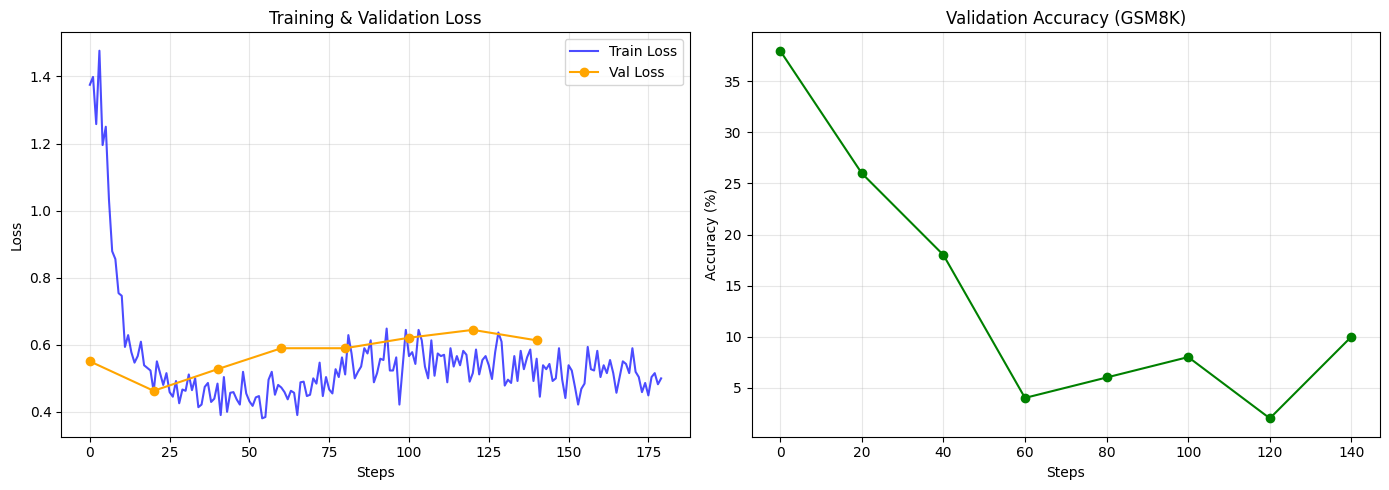

In [58]:
print("Training completed!")
print(f"Final accuracy: {last_accuracy*100:.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, color="blue", label="Train Loss", alpha=0.7)
ax1.plot(np.arange(0, len(val_losses)) * yaml_config.eval_every, val_losses, color="orange", label="Val Loss", marker='o')
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(np.arange(0, len(val_accuracies)) * yaml_config.eval_every, [a*100 for a in val_accuracies], color="green", marker='o')
ax2.set_title("Validation Accuracy (GSM8K)")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Accuracy (%)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()